In [54]:
# import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.cluster import KMeans

In [121]:
# Define the class of traditional user based collaborative filtering
class UserBasedCF:
    def __init__(self, filepath, k=10, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_sim_matrix = self.user_similarity()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate the similarity between users with cosine similarity using train data
    def user_similarity(self):
        print("计算用户相似度矩阵...")
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    C[u][v] += 1
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        return W

    # recommend items for each user
    def recommend(self):
        print("为每个用户推荐物品...")
        rank = dict()
        cnt = dict()
        for user in self.train_data.keys():
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for v, wuv in sorted(self.user_sim_matrix[user].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        return rank

    # calculate the precision
    def precision(self):
        print("计算准确率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += self.n
        print("准确率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the recall
    def recall(self):
        print("计算召回率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += len(tu)
        print("召回率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the mae
    def mae(self):
        print("计算平均绝对误差...")
        mae = 0
        cnt = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    mae += abs(pui - tu[item])
                    cnt += 1
        print("平均绝对误差为：%.4f" % (mae / cnt))
        return mae / cnt

In [122]:
# Define the class of traditional user based collaborative filtering
class UserBasedCFP:
    def __init__(self, filepath, k=10, n=10):
        self.filepath = filepath
        self.k = k
        self.n = n
        self.data = self.load_data()
        self.train_data, self.test_data = self.split_data()
        self.user_sim_matrix = self.user_similarity()
        self.recommendation = self.recommend()

    # load data
    def load_data(self):
        print("加载数据...")
        rating = pd.read_csv(self.filepath)
        train_dict = rating.iloc[:,:3].to_dict('split')
        data = train_dict['data']
        return data

    # split data
    def split_data(self):
        print("分割数据...")
        train_data = {}
        test_data = {}
        # control the random seed
        np.random.seed(1)
        for user, item, rating in self.data:
            if np.random.rand() < 0.8:
                if user not in train_data:
                    train_data[user] = {}
                train_data[user][item] = rating
            else:
                if user not in test_data:
                    test_data[user] = {}
                test_data[user][item] = rating
        return train_data, test_data

    # calculate the similarity between users with cosine similarity using train data
    def user_similarity(self):
        print("计算用户相似度矩阵...")
        # build the inverse table for item_users
        item_users = dict()
        for user, items in self.train_data.items():
            for item in items.keys():
                if item not in item_users:
                    item_users[item] = set()
                item_users[item].add(user)
        # calculate co-rated items between users
        C = dict()
        N = dict()
        for item, users in item_users.items():
            for u in users:
                if u not in N:
                    N[u] = 0
                N[u] += 1
                for v in users:
                    if u == v:
                        continue
                    if u not in C:
                        C[u] = {}
                    if v not in C[u]:
                        C[u][v] = 0
                    # C[u][v] += 1
                    C[u][v] += 1 / np.log(1 + len(users) * 1.0)
        # calculate finial similarity matrix W
        W = dict()
        for u, related_users in C.items():
            if u not in W:
                W[u] = {}
            for v, cuv in related_users.items():
                W[u][v] = cuv / np.sqrt(N[u] * N[v])
        return W

    # recommend items for each user
    def recommend(self):
        print("为每个用户推荐物品...")
        rank = dict()
        for user in self.train_data.keys():
            rank[user] = dict()
            interacted_items = self.train_data[user]
            for v, wuv in sorted(self.user_sim_matrix[user].items(), key=lambda x: x[1], reverse=True)[0:self.k]:
                for i, rvi in self.train_data[v].items():
                    if i in interacted_items:
                        continue
                    if i not in rank[user]:
                        rank[user][i] = 0
                    rank[user][i] += wuv * rvi
            max_score = max(rank[user].values())
            min_score = min(rank[user].values())
            for i in rank[user].keys():
                rank[user][i] = ((rank[user][i] - min_score) / (max_score - min_score)) * 5
        return rank

    # calculate the precision
    def precision(self):
        print("计算准确率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += self.n
        print("准确率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the recall
    def recall(self):
        print("计算召回率...")
        hit = 0
        all = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    hit += 1
            all += len(tu)
        print("召回率为：%.4f" % (hit / (all * 1.0)))
        return hit / (all * 1.0)

    # calculate the mae
    def mae(self):
        print("计算平均绝对误差...")
        mae = 0
        cnt = 0
        for user in self.train_data.keys():
            tu = self.test_data[user]
            rank = self.recommendation[user]
            for item, pui in sorted(rank.items(), key=lambda x: x[1], reverse=True)[0:self.n]:
                if item in tu:
                    mae += abs(pui - tu[item])
                    cnt += 1
        print("平均绝对误差为：%.4f" % (mae / cnt))
        return mae / cnt

In [128]:
# calculate the precision, recall, mse for different k value, n = 10
k_list = [5, 10, 15, 20, 30, 40, 50]
precision_list_2 = []
recall_list_2 = []
mae_list_2 = []
for k in k_list:
    ubfp = UserBasedCFP(filepath='ml-latest-small/ratings.csv', k=k)
    precision_list_2.append(ubfp.precision())
    recall_list_2.append(ubfp.recall())
    mae_list_2.append(ubfp.mae())

加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2241
计算召回率...
召回率为：0.0678
计算平均绝对误差...
平均绝对误差为：0.8907
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2518
计算召回率...
召回率为：0.0762
计算平均绝对误差...
平均绝对误差为：0.8185
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2621
计算召回率...
召回率为：0.0793
计算平均绝对误差...
平均绝对误差为：0.8064
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2649
计算召回率...
召回率为：0.0802
计算平均绝对误差...
平均绝对误差为：0.7701
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2761
计算召回率...
召回率为：0.0835
计算平均绝对误差...
平均绝对误差为：0.7716
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2757
计算召回率...
召回率为：0.0834
计算平均绝对误差...
平均绝对误差为：0.7617
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2741
计算召回率...
召回率为：0.0829
计算平均绝对误差...
平均绝对误差为：0.7597


In [129]:
# calculate the precision, recall, mse for different k value, n = 10
k_list = [5, 10, 15, 20, 30, 40, 50]
precision_list = []
recall_list = []
mae_list = []
for k in k_list:
    ubf = UserBasedCF(filepath='ml-latest-small/ratings.csv', k=k)
    precision_list.append(ubf.precision())
    recall_list.append(ubf.recall())
    mae_list.append(ubf.mae())

加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2318
计算召回率...
召回率为：0.0701
计算平均绝对误差...
平均绝对误差为：0.8867
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2531
计算召回率...
召回率为：0.0766
计算平均绝对误差...
平均绝对误差为：0.8335
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2608
计算召回率...
召回率为：0.0789
计算平均绝对误差...
平均绝对误差为：0.8022
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2692
计算召回率...
召回率为：0.0814
计算平均绝对误差...
平均绝对误差为：0.7756
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2736
计算召回率...
召回率为：0.0828
计算平均绝对误差...
平均绝对误差为：0.7773
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2728
计算召回率...
召回率为：0.0825
计算平均绝对误差...
平均绝对误差为：0.7633
加载数据...
分割数据...
计算用户相似度矩阵...
为每个用户推荐物品...
计算准确率...
准确率为：0.2736
计算召回率...
召回率为：0.0828
计算平均绝对误差...
平均绝对误差为：0.7622


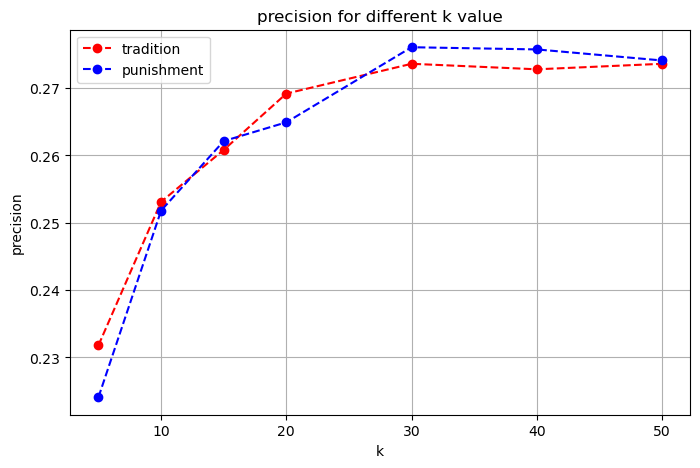

In [133]:
# create graph for precision
plt.figure(figsize=(8, 5))
plt.plot(k_list, precision_list, label='tradition', marker='o', color='r', linestyle='--')
plt.plot(k_list, precision_list_2, label='punishment', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('precision for different k value')
plt.legend()
plt.show()

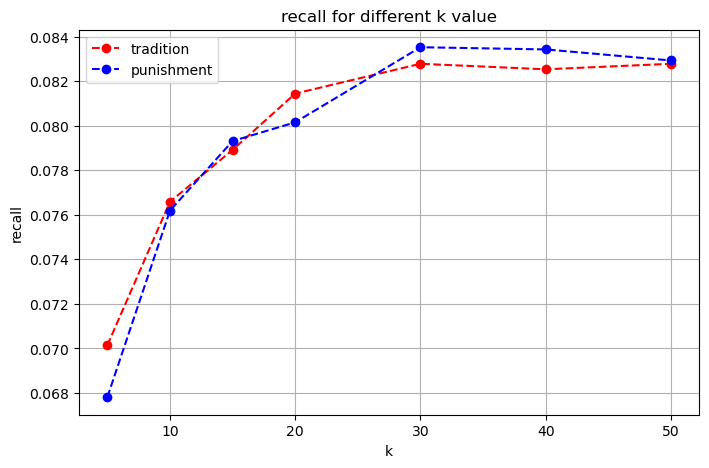

In [134]:
# create graphs for recall
plt.figure(figsize=(8, 5))
plt.plot(k_list, recall_list, label='tradition', marker='o', color='r', linestyle='--')
plt.plot(k_list, recall_list_2, label='punishment', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('recall')
plt.title('recall for different k value')
plt.legend()
plt.show()

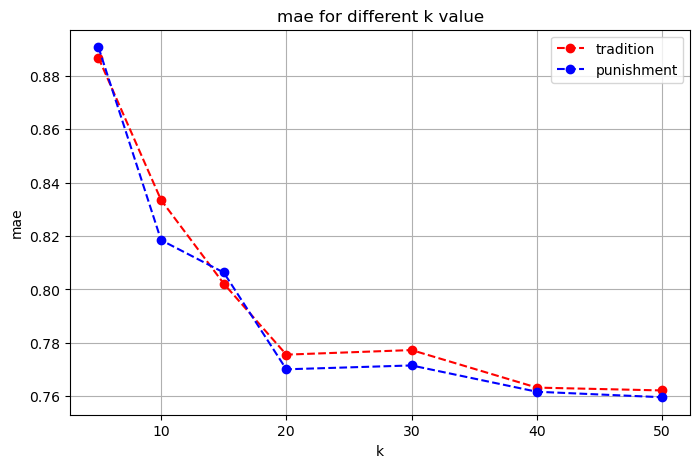

In [135]:
# create graph for mae
plt.figure(figsize=(8, 5))
plt.plot(k_list, mae_list, label='tradition', marker='o', color='r', linestyle='--')
plt.plot(k_list, mae_list_2, label='punishment', marker='o', color='b', linestyle='--')
plt.grid(True)
plt.xlabel('k')
plt.ylabel('mae')
plt.title('mae for different k value')
plt.legend()
plt.show()